In [25]:
from keras.datasets import boston_housing
from keras import models
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os  # Fix plot issue on Mac OS X
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Load the data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In [9]:
# Take a look at the data (collected in the mid-1970's)
# Each of the 13 features are elements like per capita crime rate, average number of rooms per dwelling,
# accessibility to highways, etc.
print(train_data.shape)
print(test_data.shape)
print(train_targets[:10])  # Note: these are house prices in thousands of dollars

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


In [ ]:
# Z-score the data, i.e. put most of the data in the -1 to 1 range
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean  # Note: always save off the mean and std of trianing data, never z-score on the test data
test_data /= std

In [18]:
# Construct a model
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    # Loss: mean squared error
    # Metric: mean absolute error (absolute value of error)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    
    return model

In [21]:
# Note: in this case, as there are so few data points, you should be using
# k-fold cross-validation, as we can't afford to set aside test data.
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []


for i in range(k):
    print('Processing fold #', i + 1)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4


In [23]:
# Scores vary a fair bit, reporting the mean seems to be a more logical/fair choice
print(all_scores)
print(np.mean(all_scores))

[3.432507165587775, 3.2517502307891846, 3.3888754490578528, 3.687688678798109]
3.4402053810582305


In [28]:
# Note: in this case, as there are so few data points, you should be using
# k-fold cross-validation, as we can't afford to set aside test data.
k = 4
num_epochs = 500
all_mae_histories = []


for i in range(k):
    print('Processing fold #', i + 1)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                            axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        epochs=num_epochs, batch_size=1, verbose=0,
                        validation_data = (val_data, val_targets))
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)
    

Processing fold # 1
Processing fold # 2
Processing fold # 3
Processing fold # 4


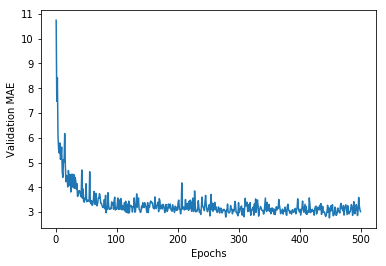

In [29]:
# Look at the average absolute error over time. It's a pretty ugly curve, we will smooth it next.
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

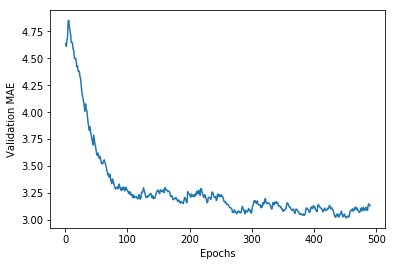

In [31]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [32]:
# Train the final production model
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 2ms/step


In [33]:
test_mae_score

7.859501146802716